# Deep learning with keras and tensorflow: RNN and regression models

*Authors: Evan Carey*

*Copyright 2019-2020, BH Analytics, LLC*

## Overview

In this session, we will explore implementing an deep learning model with recurrent neural layers, often call an recurrent neural network (RNN). 

## Libraries

First let's import the libraries we will be using.

In [1]:
# colab specific code:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#import os
#import pathlib
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Set default figure size to be larger
# this may only work in matplotlib 2.0+!
from IPython.core.interactiveshell import InteractiveShell
matplotlib.rcParams['figure.figsize'] = [10.0, 6.0]
# Enable multiple outputs from jupyter cells
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Get Version information
print("Pandas version: {0}".format(pd.__version__))
print("Matplotlib version: {0}".format(matplotlib.__version__))
print("Numpy version: {0}".format(np.__version__))
print("Tensorflow version: {0}".format(tf.__version__))

Pandas version: 0.25.3
Matplotlib version: 3.1.1
Numpy version: 1.17.4
Tensorflow version: 2.0.0


 ## Concrete Compressive Strength Data

We will use a classic dataset examining variation in concrete compressive strength as a function of various ingredients used in the manufacturing process. The outcome is compressive strength, a continuous variable. There are 8 inputs and 1030 rows. 

-  Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
-  Age -- quantitative -- Day (1~365) -- Input Variable

Here is the reference for the data:

>  I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)

Check the readme for more details on this dataset. 


In [4]:
# import the dataset
url = r'https://raw.githubusercontent.com/evan-paul-carey/deep-learning-workshop/master/Course_materials/data/concrete.csv'
concrete_source = \
    pd.read_csv(url)
concrete_source.head()
concrete_source.tail()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.401235


In [5]:
# rename the variables to make life easier ;)
# use the re module
# look for paranthesis, only keep first part
import re
temp_names = [re.split(' *\(', x)[0] for x in concrete_source.columns]
# sub spaces for underscores
concrete_source.columns = [re.sub(' +', '_', x) for x in temp_names]
concrete_source.head()

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Since we have no categorical data, we can just use the `.describe()` method

In [6]:
# Describe all the data
concrete_source.describe(include='all')

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


We will check for missing as well:

In [7]:
# summarize missing by column
concrete_source.isna().sum()

Cement                           0
Blast_Furnace_Slag               0
Fly_Ash                          0
Water                            0
Superplasticizer                 0
Coarse_Aggregate                 0
Fine_Aggregate                   0
Age                              0
Concrete_compressive_strength    0
dtype: int64

We can see there is no missing data. The average compressive strength is 35.8, but the minimum is 2.3 while the max is 82.5. We want to implement a neural network that captures the non-linear and interactions in these inputs and then predicts compressive strength as a function of the inputs. 

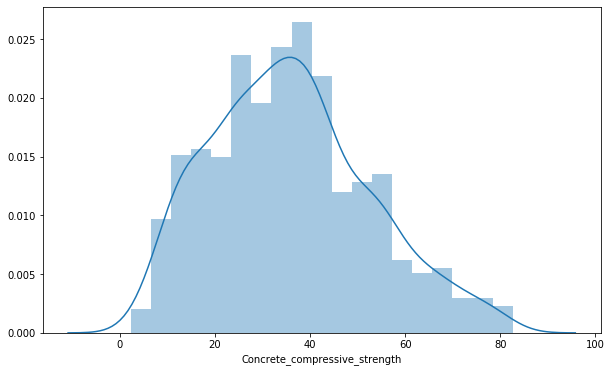

In [8]:
# check the distribution of the outcome
sns.distplot(concrete_source['Concrete_compressive_strength'])

## Setting up a traing/validation/testing dataset

Recall our goal in machine learning in general - to develop an algorithm that minimizes **generalization error**.

However, we can't directly observe **generalization error**, since it is based on out of sample data. 

We need to set up a separate training and testing dataset for our models. We will use the training dataset to train model parameters, then use the the testing dataset to estimate generalization error (instead of training error). I will use a random subset of the data in this case.

> Other options can include leveraging time series elements of our data (if present), or leveraging clusters in our data (like stores, or plants, or customers). However we don't have those elements in this dataset, so we will use a random subset. 

In [9]:
# initial split - default is to shuffle data and randomly split
concrete_train = concrete_source.sample(frac=0.8,
                                       random_state=0)
concrete_test = concrete_source.drop(concrete_train.index)
# check dims
print('training data size:', concrete_train.shape)
print('testing data size:', concrete_test.shape)

training data size: (824, 9)
testing data size: (206, 9)


## Convert to numpy objects

We need to end up with numpy X and Y matrices to use as inputs to the keras workflow. There are a number of possible ways to do this. In this case, we have no categorical variables, so it is a bit easier. If there were categorical variables we would need to decide how to represent them as numbers. I good choice would be one hot encoding, or dummy coding. You could use  the `get_dummies()` function from `Pandas`, or the `patsy` package to adopt an R-style formula interface to generate the appropriate matrices (or other ways). 

In [10]:
# pd.get_dummies()
## create numpy arrays from the target and inputs
Y_train = concrete_train.pop('Concrete_compressive_strength').values
Y_test = concrete_test.pop('Concrete_compressive_strength').values
X_train = concrete_train.values
X_test = concrete_test.values

## Build the first keras model

We will start with the equivalent model to a linear regression. The recommended default optimizer to use is `rmsprop`, so we will start there. 

> Notice that I am using the tensorflow.keras module instead of just keras. These are slightly different - tensorflow had imported the keras API into their library. There are minor differences, so this is important to note!

In [11]:
# import needed parts
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
# build a simple linear model


def build_model1():
    model = Sequential()
    model.add(Dense(1,
                    activation='linear',
                    input_dim=X_train.shape[1]))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

We will need to scale the training and testing data in a consistent manner. Let's use the sklearn `StandardScaler()` to accomplish this. This will apply the same transformation (based on the initial `.fit()` call) to subsequent datasets. 

In [12]:
# Capture mean and stdev
# we will want to use this mean and stdev on future data!
x_mean = np.mean(X_train,axis=0) # column means
x_std = np.std(X_train,axis=0) # column std

In [13]:
# write function to normalize
def norm(x,mean,std):
  return (x - mean) / std

In [14]:
# normalize the x values
X_train_s = norm(X_train,x_mean,x_std)
# check this worked!
# means should be zero, std should be 1
print('Column means are:')
np.mean(X_train_s,axis=0)
print('Column stdev are:')
np.std(X_train_s,axis=0)

Column means are:


array([ 2.43602334e-16, -1.25034826e-16,  8.62309145e-17, -6.88769430e-16,
        1.55215646e-16,  1.13178075e-16, -9.45306401e-16,  3.66481387e-17])

Column stdev are:


array([1., 1., 1., 1., 1., 1., 1., 1.])

Now we can fit the model to the dataset and investigate the results.

In [15]:
# fit this model/architecture to my data
regr1 = build_model1()
regr1.fit(X_train_s,
          Y_train,
          epochs=40,
          validation_split=0.2)

Train on 659 samples, validate on 165 samples
Epoch 1/40
659/659 [==============================] - 1s 1ms/sample - loss: 1513.7251 - mae: 35.4257 - val_loss: 1631.7784 - val_mae: 36.9001
Epoch 2/40
659/659 [==============================] - 0s 87us/sample - loss: 1511.3276 - mae: 35.4025 - val_loss: 1629.4056 - val_mae: 36.8782
Epoch 3/40
659/659 [==============================] - 0s 84us/sample - loss: 1509.1470 - mae: 35.3813 - val_loss: 1627.0617 - val_mae: 36.8563
Epoch 4/40
659/659 [==============================] - 0s 84us/sample - loss: 1507.0057 - mae: 35.3603 - val_loss: 1624.7306 - val_mae: 36.8347
Epoch 5/40
659/659 [==============================] - 0s 85us/sample - loss: 1504.8934 - mae: 35.3399 - val_loss: 1622.5281 - val_mae: 36.8132
Epoch 6/40
659/659 [==============================] - 0s 86us/sample - loss: 1502.8020 - mae: 35.3186 - val_loss: 1620.1952 - val_mae: 36.7915
Epoch 7/40
659/659 [==============================] - 0s 78us/sample - loss: 1500.6493 - mae: 35.

We can investigate the model object by asking for the layer weights (just the slope and one weight per input in this model) by asking for the model summary. 

In [16]:
# summarize model
regr1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Retrieve the weights
regr1.get_weights()

[array([[ 0.9072434 ],
        [ 0.21403272],
        [-0.09804083],
        [-0.6777894 ],
        [ 0.45452335],
        [-0.5675199 ],
        [-0.19644596],
        [ 0.8521321 ]], dtype=float32), array([0.84647405], dtype=float32)]

A good way to understand if the model has fit is to monitor the training error and the validation error for both the loss function (MSE in this case), and another sensible metric (MAE). 

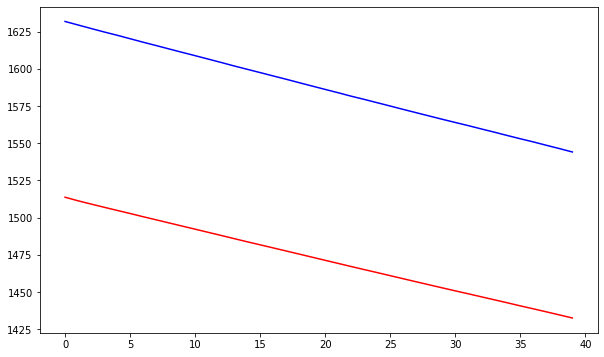

In [18]:
## plot the loss function per epoch
plt.plot(regr1.history.history['loss'],
        color='red')
plt.plot(regr1.history.history['val_loss'],
        color='blue')

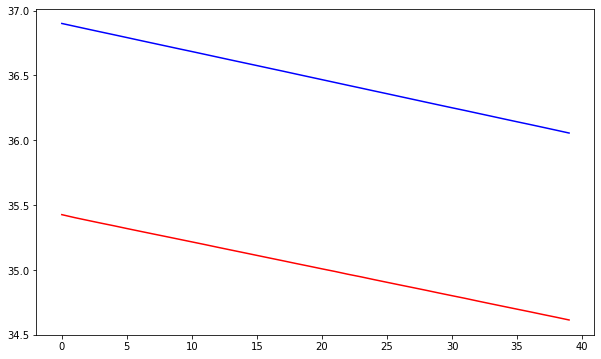

In [19]:
## plot the loss function per epoch
plt.plot(regr1.history.history['mae'],
         color='red')
plt.plot(regr1.history.history['val_mae'],
         color='blue')

It looks like the model is making progress, but we clearly need to run it for more epochs to get 'convergence'. Let's do that..

In [20]:
# fit this model/architecture to my data
regr1 = build_model1()
regr1.fit(X_train_s,
          Y_train,
          epochs=2000,
          validation_split=0.2,
          verbose=0)

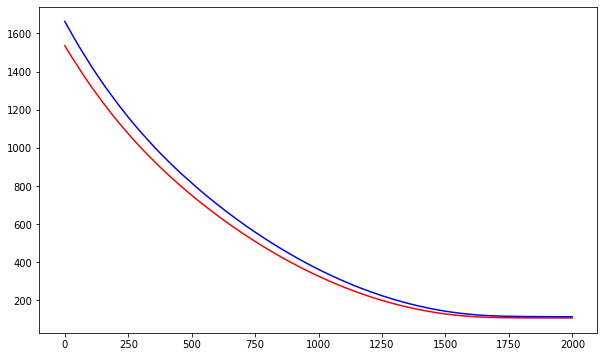

In [21]:
# plot the loss function per epoch
plt.plot(regr1.history.history['loss'],
         color='red')
plt.plot(regr1.history.history['val_loss'],
         color='blue')

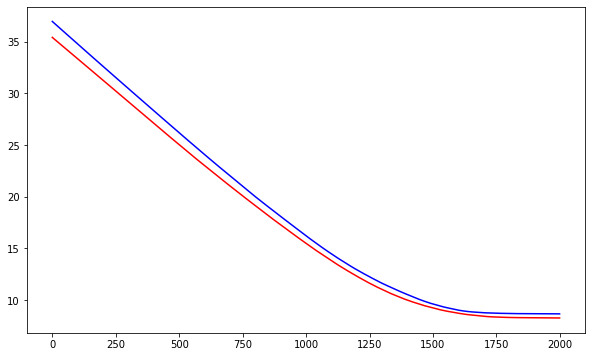

In [22]:
# plot the loss function per epoch
plt.plot(regr1.history.history['mae'],
         color='red')
plt.plot(regr1.history.history['val_mae'],
         color='blue')

It looks like the model converged by the 1700 epoch or so...let's look at those numbers:

In [23]:
# print metrics from the 15th epoch
regr1.history.history['val_loss'][1700:1725]
regr1.history.history['val_loss'][1975:2000]

regr1.history.history['val_mae'][1700:1725]
regr1.history.history['val_mae'][1975:2000]

[117.66025866884173,
 117.61190666429924,
 117.56391231652462,
 117.51564118356416,
 117.4730273622455,
 117.43914050477923,
 117.39339238947088,
 117.35209526293205,
 117.30992251309482,
 117.26306882916074,
 117.22444448760062,
 117.18501799612335,
 117.14248042251124,
 117.0955367117217,
 117.05638977975556,
 117.01613408868963,
 116.97160274621213,
 116.92542058771306,
 116.88087199818004,
 116.8400966759884,
 116.80765311501243,
 116.76679470177852,
 116.72613932291667,
 116.69976390491833,
 116.6692011977687]

[113.84275230638909,
 113.84028190843986,
 113.8374134872899,
 113.83815432461826,
 113.83325445001776,
 113.82979264692827,
 113.82137219978101,
 113.82080452658913,
 113.81818006110913,
 113.82024378921047,
 113.81505737304687,
 113.81673459139738,
 113.81376019102154,
 113.81104477391098,
 113.80826628713896,
 113.8065605394768,
 113.80209401448568,
 113.80002903793797,
 113.79916631525214,
 113.79611159815933,
 113.79315352006392,
 113.79609902121804,
 113.79185684666488,
 113.79254418575402,
 113.78854240648674]

[8.774533,
 8.773382,
 8.772302,
 8.771153,
 8.770182,
 8.769362,
 8.76823,
 8.767237,
 8.766171,
 8.764937,
 8.763969,
 8.762831,
 8.76169,
 8.760586,
 8.759717,
 8.758524,
 8.7572565,
 8.756074,
 8.754797,
 8.753909,
 8.753133,
 8.752105,
 8.7508955,
 8.750383,
 8.749649]

[8.669551,
 8.66963,
 8.669398,
 8.669315,
 8.669321,
 8.66899,
 8.668689,
 8.668792,
 8.668624,
 8.668693,
 8.668537,
 8.668539,
 8.668366,
 8.668301,
 8.668155,
 8.668201,
 8.667929,
 8.66804,
 8.668178,
 8.668148,
 8.667967,
 8.668256,
 8.667961,
 8.667979,
 8.667872]

Actually it looks like the validation error started getting a little bit worse towards the end! This could be a symptom of overfitting, although the current model does not have much capacity (just a linear model). 

We could find the minimum validation loss:

In [24]:
print('The min validation loss of',
      np.min(regr1.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr1.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr1.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr1.history.history['val_mae']))


The min validation loss of 113.78854240648674 ,
 was at epoch 1999
The min validation mae of 8.667872 ,
 was at epoch 1999


That is a bit inconclusive....we are probably OK with regard to overfitting here. Let's investigate fitting a more flexible model...

## Build a more complex model

We can add complexity to our model by increasing the **depth** (adding hidden layers), and also increasing the **width** (adding more neurons per layer). 

In [25]:
# build a 2 layer neural network
def build_model2():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    input_dim=X_train.shape[1]))
    model.add(Dense(64,
                    activation='relu'))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [26]:
# fit this model/architecture to my data
regr2 = build_model2()
regr2.fit(X_train_s,
          Y_train,
          epochs=400,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [27]:
# summarize model
regr2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Retrieve the weights
# regr2.get_weights()
# This prints all the weights (4,000 +)

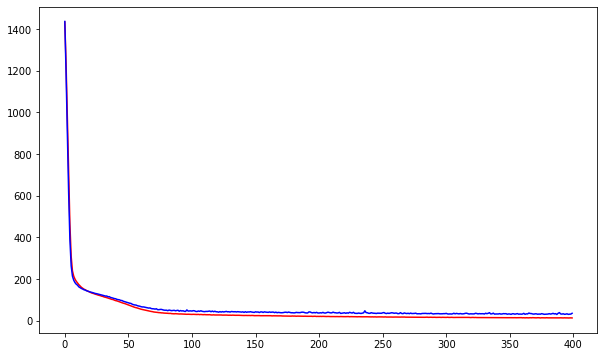

In [29]:
# plot the loss function per epoch
plt.plot(regr2.history.history['loss'],
         color='red')
plt.plot(regr2.history.history['val_loss'],
         color='blue')

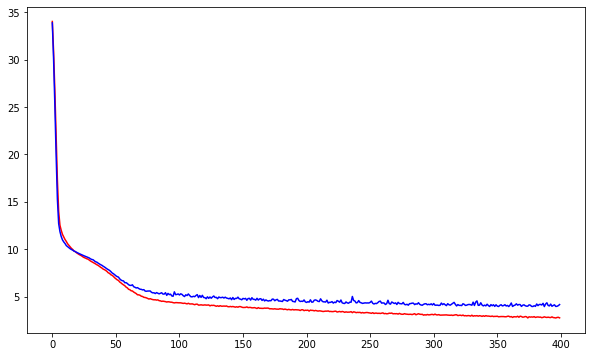

In [30]:
# plot the loss function per epoch
plt.plot(regr2.history.history['mae'],
         color='red')
plt.plot(regr2.history.history['val_mae'],
         color='blue')

This convergence pattern looks pretty good! How well did we do regarding error prediction? 

In [31]:
print('The min validation loss of',
      np.min(regr2.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr2.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_mae']))

The min validation loss of 29.994093357432973 ,
 was at epoch 387
The min validation mae of 3.9390666 ,
 was at epoch 387


This implies we could run this for a bit longer since we have not yet overfit the data. Let's try more Epochs and look at the convergence again:

In [32]:
# fit this model/architecture to my data
regr2 = build_model2()
regr2.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.3,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [33]:
# summarize model
regr2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Retrieve the weights
# regr2.get_weights()
# This prints all the weights (4,000 +)

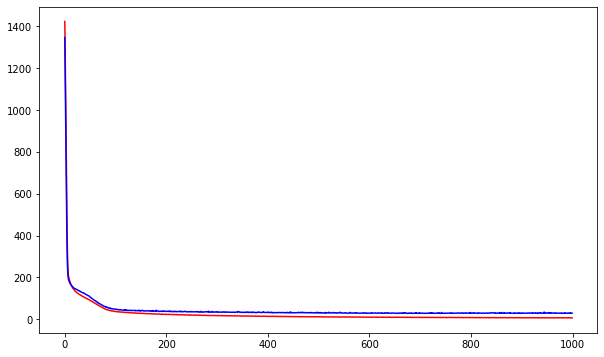

In [35]:
# plot the loss function per epoch
plt.plot(regr2.history.history['loss'],
         color='red')
plt.plot(regr2.history.history['val_loss'],
         color='blue')

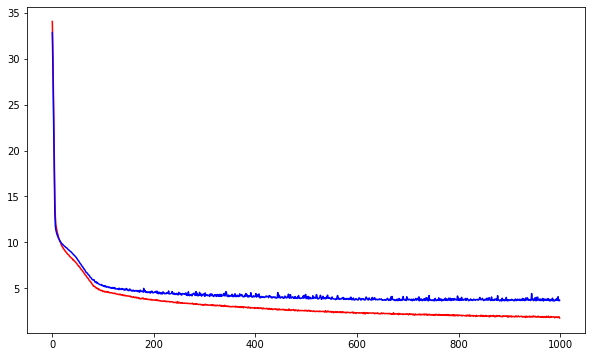

In [36]:
# plot the loss function per epoch
plt.plot(regr2.history.history['mae'],
         color='red')
plt.plot(regr2.history.history['val_mae'],
         color='blue')

This convergence pattern still looks pretty good! How well did we do regarding error prediction? 

In [37]:
print('The min validation loss of',
      np.min(regr2.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr2.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_mae']))

The min validation loss of 27.550448386899888 ,
 was at epoch 740
The min validation mae of 3.6204135 ,
 was at epoch 967


This makes me think we have reached convergence by 1000 epochs, but we did need at least ~800 to get there. 

## Build a more complex model with dropout

It is possible we could get a better model fit on the validation dataset if we introduce some form of regularization. 

> A good general definition for Regularization is any modifications we make intending to increase generalization error at the expense of training error. 

One form of regularization is model dropout. This is easily implemented in keras:

In [38]:
# build a two layer neural network with regularization
from tensorflow.keras.layers import Dropout
def build_model3():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [39]:
# fit this model/architecture to my data
regr3 = build_model3()
regr3.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [40]:
## summarize model
regr3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

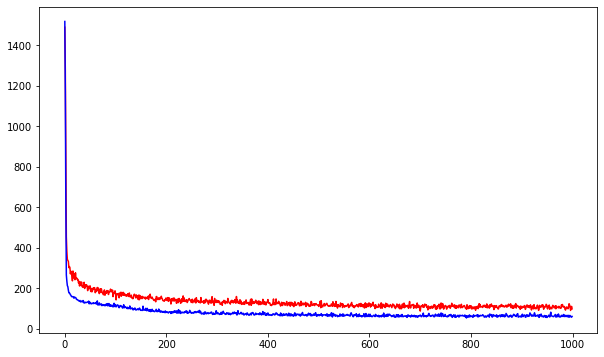

In [41]:
## plot the loss function per epoch
plt.plot(regr3.history.history['loss'],
        color='red')
plt.plot(regr3.history.history['val_loss'],
        color='blue')

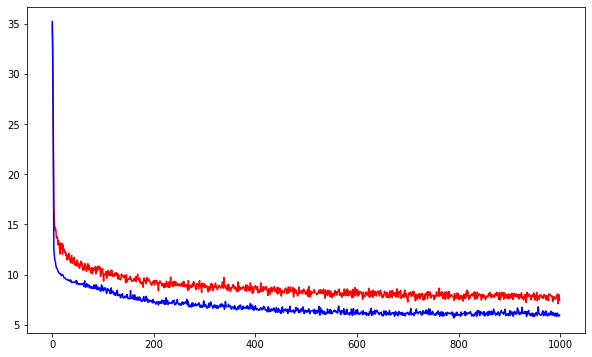

In [42]:
## plot the loss function per epoch
plt.plot(regr3.history.history['mae'],
         color='red')
plt.plot(regr3.history.history['val_mae'],
         color='blue')

In [43]:
print('The min validation loss of',
      np.min(regr3.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr3.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr3.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr3.history.history['val_mae']))

The min validation loss of 52.39430791681463 ,
 was at epoch 791
The min validation mae of 5.67797 ,
 was at epoch 791


This is looking good. The model seemed to have converged by the 900 epoch or so, overfit does not seem to be an issue. We are at a bit higher error validation error than we were in the prior models though.  

## Build a more complex model with dropout, add L1 regularization

Another form of regularization we can apply is through applying penalties to the weights. This is exactly like what you have learned before in the context of penalized linear models (LASSO, Ridge, Elastic net...)

We can apply either L1, L2, or both penalties. 

-  Typically we penalize the weights but not the bias terms of the affine transformation for each neuron. 
-  We will typically use the same weight across the network, although we could consider optimizing a different weight for each neuron with input(s).
    -  This would be expensive (large hyper-parameter space to search). 
-  L2 penalty
    -  Like ridge regression. Reduces correlated inputs, but leaves weights in the model as small values. 
-  L1 penalty
    -  Like LASSO regression. Eliminates some weights, induces sparsity. 



Some notes on the keras syntax:

-  kernel_regularizer:
    -  This will regularize the weights matrix (the Beta’s)
-  activity_regularizer:
    -  This will regularize the output of the neuron (the activation function output)

-  bias_regularizer:
    -  This will regularize the bias term for the neuron

In [44]:
from tensorflow.keras.regularizers import l1
l1_penalty = 0.1
# build a two layer neural network with regularization


def build_model4():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [45]:
# fit this model/architecture to my data
regr4 = build_model4()
regr4.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [46]:
# summarize model
regr4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

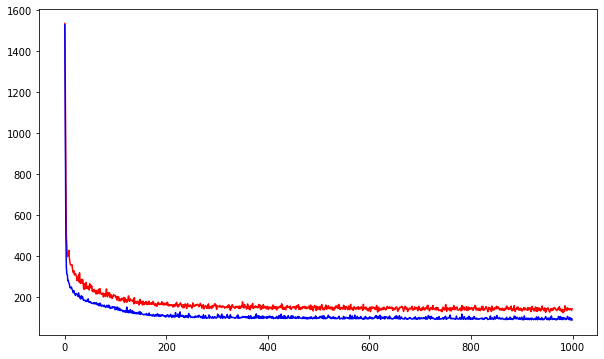

In [47]:
# plot the loss function per epoch
plt.plot(regr4.history.history['loss'],
         color='red')
plt.plot(regr4.history.history['val_loss'],
         color='blue')

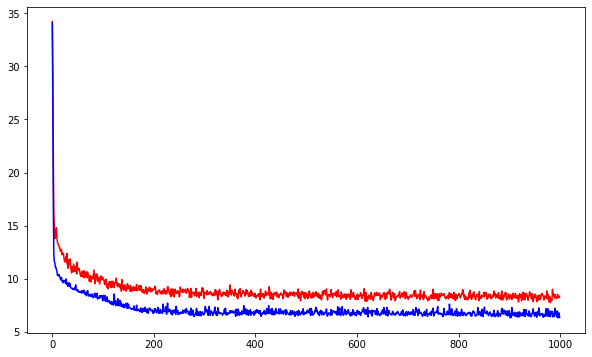

In [48]:
# plot the loss function per epoch
plt.plot(regr4.history.history['mae'],
         color='red')
plt.plot(regr4.history.history['val_mae'],
         color='blue')

In [49]:
print('The min validation loss of',
      np.min(regr4.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr4.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr4.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr4.history.history['val_mae']))

The min validation loss of 88.25270323319869 ,
 was at epoch 954
The min validation mae of 6.3125644 ,
 was at epoch 996


The model convergence looked good again (maybe could run longer), but the validation metrics are not better than without regularization. Perhaps we need a different strength penalty (different l1)?

## Build a more complex model with dropout, add L1 regularization, smaller weight. 

In [50]:
l1_penalty = 0.001
# build a two layer neural network with regularization


def build_model5():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='linear'))
    model.compile(optimizer='rmsprop',
                  loss='mse',  # mean squared error
                  metrics=['mae'])  # mean absolute error
    return model

In [51]:
# fit this model/architecture to my data
regr5 = build_model5()
regr5.fit(X_train_s,
          Y_train,
          epochs=1000,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and intercept in this model), or by asking for the model summary. 

In [52]:
# summarize model
regr5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

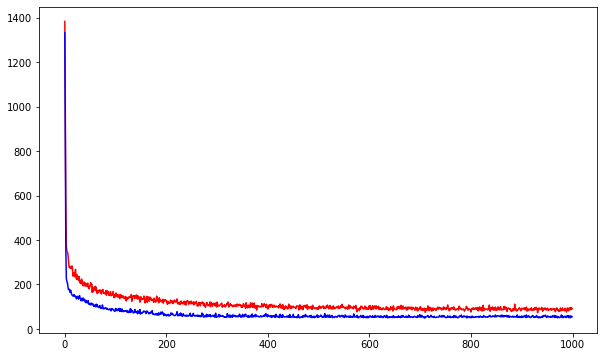

In [53]:
# plot the loss function per epoch
plt.plot(regr5.history.history['loss'],
         color='red')
plt.plot(regr5.history.history['val_loss'],
         color='blue')

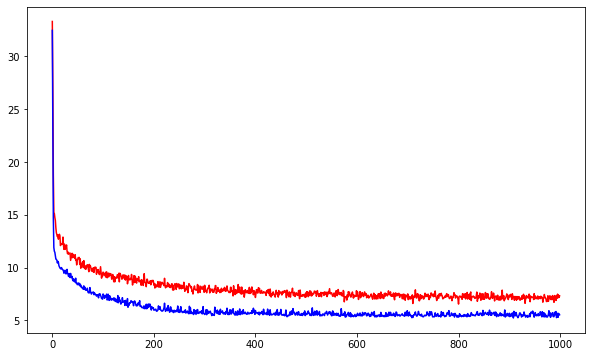

In [54]:
# plot the loss function per epoch
plt.plot(regr5.history.history['mae'],
         color='red')
plt.plot(regr5.history.history['val_mae'],
         color='blue')

In [55]:
print('The min validation loss of',
      np.min(regr5.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr5.history.history['val_loss']))

print('The min validation mae of',
      np.min(regr5.history.history['val_mae']),
      ',\n was at epoch',
      np.argmin(regr5.history.history['val_mae']))

The min validation loss of 49.4000906048399 ,
 was at epoch 792
The min validation mae of 5.2348046 ,
 was at epoch 908


The penalty gave us a similar result here. Sometimes (although possibly not on this dataset), regularization will be necessary to avoid overfitting the dataset.

Let's compare all of the models we have fit thus far to get an idea of the best model (best on the validation data).

In [56]:
# comparison of mse (loss) on validation data
regr1.history.history['val_loss'][-1]
regr2.history.history['val_loss'][-1]
regr3.history.history['val_loss'][-1]
regr4.history.history['val_loss'][-1]
regr5.history.history['val_loss'][-1]

113.78854240648674

29.085039323376073

60.211977594549005

88.57599718498462

54.708975208166876

In [57]:
# comparison of mae on validation data
regr1.history.history['val_mae'][-1]
regr2.history.history['val_mae'][-1]
regr3.history.history['val_mae'][-1]
regr4.history.history['val_mae'][-1]
regr5.history.history['val_mae'][-1]

8.667872

3.7026045

5.9737988

6.3765965

5.5330815

It looks like our second model was the best model by either the loss function (mse) or the other chosen metric (mae). 

Let's select it as the 'best model', and score it on the test data. 

In [58]:
# What happened?!?
regr2.evaluate(x=X_test,
               y=Y_test,
               verbose=0)

[235892455.14563107, 15260.101]

We need to transform the X as we did (standardize it). Good thing we set up the transformer function!

In [59]:
# we need to transform the X...
regr2.evaluate(x=norm(X_test,x_mean,x_std),
               y=Y_test, verbose=0)

[31.616650368403462, 3.9671931]

## Conclusion

In this module, we have covered a lot! 

-  We learned how to implement a regression feed-forward NN using keras. 
-  We monitored our training error and our estimate of the generalization error via a validation dataset. 
-  We investigated some forms of regularization
-  And then we finally chose the 'best' model. 